In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
np.set_printoptions(precision = 3, suppress = True)

In [2]:
from keras import backend as K

class BiasLayer(tf.keras.layers.Layer):
    def __init__(self, *args, **kwargs):
        super(BiasLayer, self).__init__(*args, **kwargs)

    def build(self, input_shape):
        print(input_shape)
        self.bias = self.add_weight('bias',
                                    shape=input_shape[1:],
                                    initializer='glorot',
                                    trainable=True)
    def call(self, x):
        return x + self.bias

class ConstantTensorInitializer(tf.keras.initializers.Initializer):
  """Initializes tensors to `t`."""

  def __init__(self, t):
    self.t = t

  def __call__(self, shape, dtype=None):
    return self.t

  def get_config(self):
    return {'t': self.t}

class ConstantTensorConstraint(tf.keras.constraints.Constraint):
  """Constrains tensors to `t`."""

  def __init__(self, t):
    self.t = t

  def __call__(self, w):
    return self.t

  def get_config(self):
    return {'t': self.t}

# all you need to create a mask matrix M, which is a NxN identity matrix
# and you can write a contraint like below
class DiagonalWeight(tf.keras.constraints.Constraint):
    """Constrains the weights to be diagonal.
    """
    def __call__(self, w):
        N = K.int_shape(w)[-1]
        m = K.eye(N)
        v = w*m
        return v

In [3]:
def init_model(nb_hidden_layers, nb_nodes_per_layer, m_periodic, n_periodic, omega, input_dim):

    # Append hidden layers
    all_layers = []

    # Initialize a feedforward neural network
    model = tf.keras.Sequential()

    # Input is two-dimensional (time + one spatial dimension)
    input_model = tf.keras.layers.InputLayer(input_shape= (input_dim,), name='input_model')
    model.add(input_model)

    # Construct first omega matrix
    omega_each_dim = omega*np.ones((input_dim,1))
    Omega_matrix = np.array([])

    for dim in range(input_dim):
        Omega_dim = np.zeros((m_periodic, input_dim))
        Omega_dim[:,dim] = omega_each_dim[dim,0]*np.ones((m_periodic,))
        Omega_matrix = np.vstack([Omega_matrix,Omega_dim]) if Omega_matrix.size else Omega_dim

    Omega = tf.Variable(Omega_matrix.T,dtype=tf.float32)

    # Create first C^inf periodic layers L_p(m,n)
    first_periodic_layer = tf.keras.layers.Dense(m_periodic*input_dim,
                                                 activation = tf.math.cos,
                                                 use_bias = True,
                                                 trainable = True,
                                                 name = 'first_periodic_layer',
                                                 kernel_initializer = ConstantTensorInitializer(Omega),
                                                 kernel_constraint = ConstantTensorConstraint(Omega),
                                                 bias_initializer = 'glorot_normal')
    all_layers.append(first_periodic_layer)
    model.add(first_periodic_layer)

    second_periodic_layer = tf.keras.layers.Dense(m_periodic*input_dim,
                                                  activation = 'tanh',
                                                  use_bias = True,
                                                  trainable = True,
                                                  name = 'second_periodic_layer',
                                                  kernel_constraint = DiagonalWeight(),
                                                  kernel_initializer = 'glorot_normal',
                                                  bias_initializer = 'glorot_normal')
    all_layers.append(second_periodic_layer)
    model.add(second_periodic_layer)

    # create the rest of the network (substitute other code here also)
    for layer in range(nb_hidden_layers):
        if layer == nb_hidden_layers-1:
            layer_name = 'second_to_last_hidden_layer'
        else:
            layer_name = 'hidden_layer_' + str(layer)

        hidden_layer = tf.keras.layers.Dense(nb_nodes_per_layer, 
                                        activation='tanh',
                                        name=layer_name,
                                        kernel_initializer= 'glorot_normal')
                                        #bias_initializer= weight_bias_initializer,
                                        #dtype=tf.float32)
        all_layers.append(hidden_layer)
        model.add(hidden_layer)

    # Output is one-dimensional
    model.add(tf.keras.layers.Dense(1))
    
    return model

## 2D second order equation $-\nabla \cdot \left((1+\frac{1}{4}\sin {2\pi x_1}\sin {2\pi x_2})\nabla \Psi\right) + \nu \Psi=- 2\pi^2 \cos{2\pi x_1}\cos{4\pi x_1}\sin^2 {2\pi x_2} - \pi^2 \sin{2\pi x_1}\sin{4\pi x_1}\cos^2 {2\pi x_2} + 20\pi^2(1+\frac{1}{4}\sin {2\pi x_1}\sin {2\pi x_2})\sin{4\pi x_1}\sin{4\pi x_2} + \nu \sin{4\pi x_1}\sin{2\pi x_2}$ with periodic BCs

## Exact solution: $\Psi(x) = \sin{4\pi x_1} \sin{2\pi x_2}$

In [4]:
nb_hidden_layers = 3
nb_nodes_per_layer = 30

input_dim = 2
m_periodic = 11
n_periodic = 30

L_period = 1.0 #2*np.pi
omega = 2*np.pi/L_period
# Initialize model aka u_\theta
model5 = init_model(nb_hidden_layers, nb_nodes_per_layer, m_periodic, n_periodic, omega, input_dim)
model5.summary()

model6 = init_model(nb_hidden_layers, nb_nodes_per_layer, m_periodic, n_periodic, omega, input_dim)
model6.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
first_periodic_layer (Dense) (None, 22)                66        
_________________________________________________________________
second_periodic_layer (Dense (None, 22)                506       
_________________________________________________________________
hidden_layer_0 (Dense)       (None, 30)                690       
_________________________________________________________________
hidden_layer_1 (Dense)       (None, 30)                930       
_________________________________________________________________
second_to_last_hidden_layer  (None, 30)                930       
_________________________________________________________________
dense (Dense)                (None, 1)                 31        
Total params: 3,153
Trainable params: 3,153
Non-trainable params: 0
______________________________________________________

## Sampling

In [5]:

a = 0
b = 1
N = 1200

nu = 0.5

# Monte Carlo points in the domain

input_data_MC = np.random.uniform(0 ,1, (N,input_dim))



# Uniform sampling in two dimension

# number of points on each dimension
M = 30 

x = np.outer(np.linspace(0,1,M), np.ones(M))
y = x.copy().T
x = x.reshape(M**2,1)
y = y.reshape(M**2,1)
input_data_uniform = np.concatenate((x, y), axis=1)

In [6]:
def trainStep_2D(x, opt, model):
    
    L = len(x)
    
    # Outer gradient for model parameters
    with tf.GradientTape() as tape:
        
        # Inner gradient for first derivative of N wrt x
        with tf.GradientTape(persistent=True) as tape1:
            tape1.watch(x)
            
            # Inner inner gradient for fi derivative of N wrt x
            with tf.GradientTape(persistent=True) as tape2:
                tape2.watch(x)
            
                N = model(x)
            
            grad_N = tape2.gradient(N, x)
            Nx = grad_N[:, 0]
            Ny = grad_N[:, 1]
        Nxx = tape1.gradient(Nx, x)[:, 0]
        Nyy = tape1.gradient(Ny, x)[:, 1]
        
        N = tf.reshape(N, [L])
        # Plug trial solution into ODE:
        divergence_error = Nxx + Nyy + 20 * np.pi**2 * np.sin(4*np.pi*x[:, 0]) * np.sin(2*np.pi*x[:, 1])
        Nx_error = Nx - 4 * np.pi * np.cos(4*np.pi*x[:, 0]) * np.sin(2*np.pi*x[:, 1])
        Ny_error = Ny - 2 * np.pi * np.sin(4*np.pi*x[:, 0]) * np.cos(2*np.pi*x[:, 1])
        N_error = N - np.sin(4*np.pi*x[:, 0]) * np.sin(2*np.pi*x[:, 1])
        
        eqn = - (1 + 1/4 * np.sin(2*np.pi*x[:, 0]) * np.sin(2*np.pi*x[:, 1])) *  divergence_error - \
        (np.pi/2 * np.cos(2*np.pi*x[:, 0]) * np.sin(2*np.pi*x[:, 1])) * Nx_error - \
        (np.pi/2 * np.sin(2*np.pi*x[:, 0]) * np.cos(2*np.pi*x[:, 1])) * Ny_error + nu * N_error
        
        loss = tf.reduce_sum(tf.square(eqn)) 
        N_loss = tf.reduce_sum(tf.square(N_error))
        gradient_loss =  tf.reduce_sum(tf.square(Nx_error) + tf.square(Ny_error))
        divergence_loss = tf.reduce_sum(tf.square(divergence_error))
        
    # Compute the gradient of loss wrt model parameters
    grads = tape.gradient(loss, model.trainable_variables)
    
    # Gradient step
    opt.apply_gradients(zip(grads, model.trainable_variables))
    
    
    return loss, N_loss, gradient_loss, divergence_loss

In [7]:
def PINNtrain(x, epochs, model):
    
    # optional, use a stopping tolerance (i.e., if loss < 1e-7 then stop training early)
    stop_tol = 1e-12
    
    # set the initial best loss seen so far to something large
    best_loss = 1e12
    best_loss_epoch = -1
    best_weights = None
    
    # Define an optimizer
    lr = tf.keras.optimizers.schedules.PolynomialDecay(0.1, epochs, 1e-4)
    opt = keras.optimizers.Adam()
    epoch_loss, N_loss, gradient_loss, divergence_loss = (np.zeros(epochs) for i in range(4))
    
    # Main training loop
    for i in range(epochs):
        
        epoch_loss[i], N_loss[i], gradient_loss[i], divergence_loss[i]  = trainStep_2D(x ,opt, model)
        
        if (np.mod(i, 100)==0):
          print("PDE loss in {}th epoch: {: 1.6e}. Last save epoch and best loss so far: {}, {: 1.6e}.".format(i, epoch_loss[i], best_loss_epoch, best_loss))
    
        if (epoch_loss[i] < best_loss):
            best_weights = model.get_weights()
            best_loss_epoch = i
            best_loss = epoch_loss[i]
            #print("Found a new best local minimum at epoch {}: loss {: 1.6e}. Saving weights.".format(i, epoch_loss[i]))
            
        if (epoch_loss[i] < stop_tol):
            print("Current model has loss {: 1.6e}, lower than stopping tolerance {: 1.6e}, stopping early at epoch {}.".format(epoch_loss[i],stop_tol,i))
            return epoch_loss, N_loss, gradient_loss, divergence_loss
    
    if (best_loss < epoch_loss[i]):
        model.set_weights(best_weights)
        print("Current loss {: 1.6e}, Best loss {: 1.6e}. Restoring best model weights.".format(epoch_loss[i],best_loss))
    else:
        print("Current loss {: 1.6e}, Best loss {: 1.6e}. Keeping current model weights.".format(epoch_loss[i],best_loss))
        
    return epoch_loss, N_loss, gradient_loss, divergence_loss

In [8]:
# train NN for Monte Carlo sample
epochs = 50000
PDE_loss1, N_loss1, gradient_loss1, divergence_loss1 = PINNtrain(tf.convert_to_tensor(input_data_MC, dtype = float), epochs, model5)


PDE loss in 0th epoch:  1.228328e+07. Last save epoch and best loss so far: -1,  1.000000e+12.
PDE loss in 100th epoch:  1.102001e+07. Last save epoch and best loss so far: 99,  1.104101e+07.
PDE loss in 200th epoch:  1.227941e+06. Last save epoch and best loss so far: 199,  1.283939e+06.
PDE loss in 300th epoch:  7.670286e+04. Last save epoch and best loss so far: 299,  7.848537e+04.
PDE loss in 400th epoch:  1.833036e+04. Last save epoch and best loss so far: 399,  1.847632e+04.
PDE loss in 500th epoch:  1.011025e+04. Last save epoch and best loss so far: 499,  1.014630e+04.
PDE loss in 600th epoch:  6.829139e+03. Last save epoch and best loss so far: 599,  6.852382e+03.
PDE loss in 700th epoch:  4.995669e+03. Last save epoch and best loss so far: 699,  5.008502e+03.
PDE loss in 800th epoch:  3.756080e+03. Last save epoch and best loss so far: 799,  3.766545e+03.
PDE loss in 900th epoch:  2.856169e+03. Last save epoch and best loss so far: 899,  2.863715e+03.
PDE loss in 1000th epoch

PDE loss in 8300th epoch:  5.776044e+02. Last save epoch and best loss so far: 8258,  5.060126e+01.
PDE loss in 8400th epoch:  8.899855e+01. Last save epoch and best loss so far: 8380,  4.921128e+01.
PDE loss in 8500th epoch:  5.345670e+01. Last save epoch and best loss so far: 8485,  4.884795e+01.
PDE loss in 8600th epoch:  1.360565e+02. Last save epoch and best loss so far: 8558,  4.809975e+01.
PDE loss in 8700th epoch:  4.671385e+02. Last save epoch and best loss so far: 8665,  4.725438e+01.
PDE loss in 8800th epoch:  7.945058e+01. Last save epoch and best loss so far: 8665,  4.725438e+01.
PDE loss in 8900th epoch:  5.313040e+01. Last save epoch and best loss so far: 8828,  4.615627e+01.
PDE loss in 9000th epoch:  5.057145e+01. Last save epoch and best loss so far: 8925,  4.536128e+01.
PDE loss in 9100th epoch:  5.775311e+01. Last save epoch and best loss so far: 9029,  4.496862e+01.
PDE loss in 9200th epoch:  4.384899e+01. Last save epoch and best loss so far: 9199,  4.411469e+01.


PDE loss in 16400th epoch:  2.027499e+02. Last save epoch and best loss so far: 16127,  2.035616e+01.
PDE loss in 16500th epoch:  1.390722e+02. Last save epoch and best loss so far: 16127,  2.035616e+01.
PDE loss in 16600th epoch:  2.518520e+01. Last save epoch and best loss so far: 16525,  2.015623e+01.
PDE loss in 16700th epoch:  6.458983e+01. Last save epoch and best loss so far: 16614,  2.000134e+01.
PDE loss in 16800th epoch:  1.924401e+01. Last save epoch and best loss so far: 16798,  1.921065e+01.
PDE loss in 16900th epoch:  5.106713e+02. Last save epoch and best loss so far: 16798,  1.921065e+01.
PDE loss in 17000th epoch:  3.531365e+01. Last save epoch and best loss so far: 16798,  1.921065e+01.
PDE loss in 17100th epoch:  2.446464e+01. Last save epoch and best loss so far: 16798,  1.921065e+01.
PDE loss in 17200th epoch:  1.898919e+02. Last save epoch and best loss so far: 16798,  1.921065e+01.
PDE loss in 17300th epoch:  2.006769e+01. Last save epoch and best loss so far: 17

PDE loss in 24500th epoch:  4.106204e+02. Last save epoch and best loss so far: 24384,  1.329045e+01.
PDE loss in 24600th epoch:  2.274517e+01. Last save epoch and best loss so far: 24384,  1.329045e+01.
PDE loss in 24700th epoch:  1.798574e+02. Last save epoch and best loss so far: 24384,  1.329045e+01.
PDE loss in 24800th epoch:  3.302624e+02. Last save epoch and best loss so far: 24384,  1.329045e+01.
PDE loss in 24900th epoch:  3.525628e+01. Last save epoch and best loss so far: 24384,  1.329045e+01.
PDE loss in 25000th epoch:  2.362297e+01. Last save epoch and best loss so far: 24384,  1.329045e+01.
PDE loss in 25100th epoch:  3.275642e+01. Last save epoch and best loss so far: 24384,  1.329045e+01.
PDE loss in 25200th epoch:  1.326912e+01. Last save epoch and best loss so far: 25185,  1.301375e+01.
PDE loss in 25300th epoch:  1.392403e+01. Last save epoch and best loss so far: 25206,  1.300304e+01.
PDE loss in 25400th epoch:  1.330185e+01. Last save epoch and best loss so far: 25

PDE loss in 32600th epoch:  5.207235e+01. Last save epoch and best loss so far: 32383,  1.105069e+01.
PDE loss in 32700th epoch:  2.514942e+01. Last save epoch and best loss so far: 32383,  1.105069e+01.
PDE loss in 32800th epoch:  3.413662e+01. Last save epoch and best loss so far: 32383,  1.105069e+01.
PDE loss in 32900th epoch:  1.783743e+02. Last save epoch and best loss so far: 32383,  1.105069e+01.
PDE loss in 33000th epoch:  1.322068e+01. Last save epoch and best loss so far: 32383,  1.105069e+01.
PDE loss in 33100th epoch:  1.150622e+01. Last save epoch and best loss so far: 32383,  1.105069e+01.
PDE loss in 33200th epoch:  1.214201e+01. Last save epoch and best loss so far: 32383,  1.105069e+01.
PDE loss in 33300th epoch:  2.694007e+01. Last save epoch and best loss so far: 32383,  1.105069e+01.
PDE loss in 33400th epoch:  9.577892e+01. Last save epoch and best loss so far: 32383,  1.105069e+01.
PDE loss in 33500th epoch:  3.487078e+01. Last save epoch and best loss so far: 32

PDE loss in 40700th epoch:  1.820878e+01. Last save epoch and best loss so far: 40617,  9.357107e+00.
PDE loss in 40800th epoch:  1.676827e+01. Last save epoch and best loss so far: 40617,  9.357107e+00.
PDE loss in 40900th epoch:  1.036202e+01. Last save epoch and best loss so far: 40617,  9.357107e+00.
PDE loss in 41000th epoch:  5.001261e+01. Last save epoch and best loss so far: 40941,  9.284486e+00.
PDE loss in 41100th epoch:  4.361437e+01. Last save epoch and best loss so far: 40941,  9.284486e+00.
PDE loss in 41200th epoch:  3.058768e+01. Last save epoch and best loss so far: 40941,  9.284486e+00.
PDE loss in 41300th epoch:  1.188709e+01. Last save epoch and best loss so far: 40941,  9.284486e+00.
PDE loss in 41400th epoch:  9.691838e+01. Last save epoch and best loss so far: 40941,  9.284486e+00.
PDE loss in 41500th epoch:  3.141685e+02. Last save epoch and best loss so far: 40941,  9.284486e+00.
PDE loss in 41600th epoch:  2.400620e+01. Last save epoch and best loss so far: 40

PDE loss in 48800th epoch:  1.891130e+01. Last save epoch and best loss so far: 48485,  7.761047e+00.
PDE loss in 48900th epoch:  3.513220e+02. Last save epoch and best loss so far: 48485,  7.761047e+00.
PDE loss in 49000th epoch:  8.464969e+01. Last save epoch and best loss so far: 48485,  7.761047e+00.
PDE loss in 49100th epoch:  8.013442e+00. Last save epoch and best loss so far: 48485,  7.761047e+00.
PDE loss in 49200th epoch:  7.916828e+00. Last save epoch and best loss so far: 49192,  7.635723e+00.
PDE loss in 49300th epoch:  2.322682e+01. Last save epoch and best loss so far: 49192,  7.635723e+00.
PDE loss in 49400th epoch:  5.874427e+01. Last save epoch and best loss so far: 49192,  7.635723e+00.
PDE loss in 49500th epoch:  1.837327e+02. Last save epoch and best loss so far: 49451,  7.573985e+00.
PDE loss in 49600th epoch:  1.650952e+01. Last save epoch and best loss so far: 49451,  7.573985e+00.
PDE loss in 49700th epoch:  1.025714e+02. Last save epoch and best loss so far: 49

In [9]:
# train NN for uniform grid
epochs = 50000
PDE_loss2, N_loss2, gradient_loss2, divergence_loss2= PINNtrain(tf.convert_to_tensor(input_data_uniform, dtype = float), epochs, model6)
PDE_loss2

PDE loss in 0th epoch:  1.084930e+07. Last save epoch and best loss so far: -1,  1.000000e+12.
PDE loss in 100th epoch:  7.772567e+06. Last save epoch and best loss so far: 99,  7.777155e+06.
PDE loss in 200th epoch:  3.828665e+06. Last save epoch and best loss so far: 199,  3.884972e+06.
PDE loss in 300th epoch:  1.351359e+05. Last save epoch and best loss so far: 299,  1.376368e+05.
PDE loss in 400th epoch:  4.589724e+04. Last save epoch and best loss so far: 399,  4.622826e+04.
PDE loss in 500th epoch:  2.507758e+04. Last save epoch and best loss so far: 499,  2.521230e+04.
PDE loss in 600th epoch:  1.515075e+04. Last save epoch and best loss so far: 599,  1.522327e+04.
PDE loss in 700th epoch:  9.704920e+03. Last save epoch and best loss so far: 699,  9.744680e+03.
PDE loss in 800th epoch:  6.747751e+03. Last save epoch and best loss so far: 799,  6.769415e+03.
PDE loss in 900th epoch:  5.149807e+03. Last save epoch and best loss so far: 891,  5.217101e+03.
PDE loss in 1000th epoch

PDE loss in 8300th epoch:  1.029834e+02. Last save epoch and best loss so far: 8230,  9.725744e+01.
PDE loss in 8400th epoch:  9.786760e+01. Last save epoch and best loss so far: 8397,  9.557143e+01.
PDE loss in 8500th epoch:  1.741296e+02. Last save epoch and best loss so far: 8408,  9.465402e+01.
PDE loss in 8600th epoch:  9.250446e+01. Last save epoch and best loss so far: 8599,  9.159489e+01.
PDE loss in 8700th epoch:  9.411947e+01. Last save epoch and best loss so far: 8599,  9.159489e+01.
PDE loss in 8800th epoch:  1.813069e+02. Last save epoch and best loss so far: 8599,  9.159489e+01.
PDE loss in 8900th epoch:  8.819626e+01. Last save epoch and best loss so far: 8899,  8.865765e+01.
PDE loss in 9000th epoch:  9.023569e+01. Last save epoch and best loss so far: 8997,  8.682948e+01.
PDE loss in 9100th epoch:  1.237815e+02. Last save epoch and best loss so far: 9007,  8.617667e+01.
PDE loss in 9200th epoch:  8.279660e+01. Last save epoch and best loss so far: 9196,  8.252942e+01.


PDE loss in 16400th epoch:  3.834138e+01. Last save epoch and best loss so far: 16394,  3.724913e+01.
PDE loss in 16500th epoch:  3.880656e+01. Last save epoch and best loss so far: 16412,  3.711525e+01.
PDE loss in 16600th epoch:  7.651808e+02. Last save epoch and best loss so far: 16412,  3.711525e+01.
PDE loss in 16700th epoch:  1.409121e+02. Last save epoch and best loss so far: 16655,  3.694855e+01.
PDE loss in 16800th epoch:  1.879019e+02. Last save epoch and best loss so far: 16750,  3.622851e+01.
PDE loss in 16900th epoch:  8.740068e+01. Last save epoch and best loss so far: 16750,  3.622851e+01.
PDE loss in 17000th epoch:  5.597147e+02. Last save epoch and best loss so far: 16750,  3.622851e+01.
PDE loss in 17100th epoch:  1.073696e+03. Last save epoch and best loss so far: 17060,  3.549762e+01.
PDE loss in 17200th epoch:  5.682408e+02. Last save epoch and best loss so far: 17164,  3.521972e+01.
PDE loss in 17300th epoch:  2.480666e+02. Last save epoch and best loss so far: 17

PDE loss in 24500th epoch:  2.745940e+01. Last save epoch and best loss so far: 24277,  2.230738e+01.
PDE loss in 24600th epoch:  8.277216e+01. Last save epoch and best loss so far: 24277,  2.230738e+01.
PDE loss in 24700th epoch:  3.410427e+01. Last save epoch and best loss so far: 24277,  2.230738e+01.
PDE loss in 24800th epoch:  2.821188e+01. Last save epoch and best loss so far: 24277,  2.230738e+01.
PDE loss in 24900th epoch:  3.201834e+01. Last save epoch and best loss so far: 24277,  2.230738e+01.
PDE loss in 25000th epoch:  2.587468e+02. Last save epoch and best loss so far: 24277,  2.230738e+01.
PDE loss in 25100th epoch:  3.273798e+01. Last save epoch and best loss so far: 24277,  2.230738e+01.
PDE loss in 25200th epoch:  2.280076e+02. Last save epoch and best loss so far: 24277,  2.230738e+01.
PDE loss in 25300th epoch:  2.371514e+01. Last save epoch and best loss so far: 25292,  2.125911e+01.
PDE loss in 25400th epoch:  5.414360e+02. Last save epoch and best loss so far: 25

PDE loss in 32600th epoch:  4.941589e+01. Last save epoch and best loss so far: 32491,  1.457311e+01.
PDE loss in 32700th epoch:  3.175112e+01. Last save epoch and best loss so far: 32491,  1.457311e+01.
PDE loss in 32800th epoch:  1.496341e+01. Last save epoch and best loss so far: 32491,  1.457311e+01.
PDE loss in 32900th epoch:  2.318569e+01. Last save epoch and best loss so far: 32828,  1.442465e+01.
PDE loss in 33000th epoch:  7.040118e+01. Last save epoch and best loss so far: 32937,  1.428072e+01.
PDE loss in 33100th epoch:  1.831555e+01. Last save epoch and best loss so far: 32937,  1.428072e+01.
PDE loss in 33200th epoch:  4.875242e+01. Last save epoch and best loss so far: 32937,  1.428072e+01.
PDE loss in 33300th epoch:  1.780572e+02. Last save epoch and best loss so far: 32937,  1.428072e+01.
PDE loss in 33400th epoch:  9.168918e+01. Last save epoch and best loss so far: 32937,  1.428072e+01.
PDE loss in 33500th epoch:  6.568576e+02. Last save epoch and best loss so far: 32

PDE loss in 40700th epoch:  1.504035e+02. Last save epoch and best loss so far: 40322,  1.056756e+01.
PDE loss in 40800th epoch:  2.473859e+01. Last save epoch and best loss so far: 40322,  1.056756e+01.
PDE loss in 40900th epoch:  1.955513e+02. Last save epoch and best loss so far: 40322,  1.056756e+01.
PDE loss in 41000th epoch:  1.252019e+01. Last save epoch and best loss so far: 40322,  1.056756e+01.
PDE loss in 41100th epoch:  4.362173e+02. Last save epoch and best loss so far: 40322,  1.056756e+01.
PDE loss in 41200th epoch:  2.613257e+01. Last save epoch and best loss so far: 40322,  1.056756e+01.
PDE loss in 41300th epoch:  2.509552e+01. Last save epoch and best loss so far: 40322,  1.056756e+01.
PDE loss in 41400th epoch:  5.864185e+01. Last save epoch and best loss so far: 40322,  1.056756e+01.
PDE loss in 41500th epoch:  1.063836e+02. Last save epoch and best loss so far: 40322,  1.056756e+01.
PDE loss in 41600th epoch:  7.149871e+01. Last save epoch and best loss so far: 40

PDE loss in 48800th epoch:  1.312801e+01. Last save epoch and best loss so far: 48114,  8.040674e+00.
PDE loss in 48900th epoch:  5.361367e+01. Last save epoch and best loss so far: 48832,  7.800711e+00.
PDE loss in 49000th epoch:  4.706347e+01. Last save epoch and best loss so far: 48832,  7.800711e+00.
PDE loss in 49100th epoch:  8.190737e+00. Last save epoch and best loss so far: 48832,  7.800711e+00.
PDE loss in 49200th epoch:  1.256439e+01. Last save epoch and best loss so far: 48832,  7.800711e+00.
PDE loss in 49300th epoch:  1.681762e+01. Last save epoch and best loss so far: 48832,  7.800711e+00.
PDE loss in 49400th epoch:  5.169370e+01. Last save epoch and best loss so far: 48832,  7.800711e+00.
PDE loss in 49500th epoch:  9.661066e+00. Last save epoch and best loss so far: 48832,  7.800711e+00.
PDE loss in 49600th epoch:  2.264652e+02. Last save epoch and best loss so far: 48832,  7.800711e+00.
PDE loss in 49700th epoch:  7.489975e+01. Last save epoch and best loss so far: 48

array([10849298.   ,  8332838.   ,  8332260.   , ...,       21.035,
             17.206,       13.473])

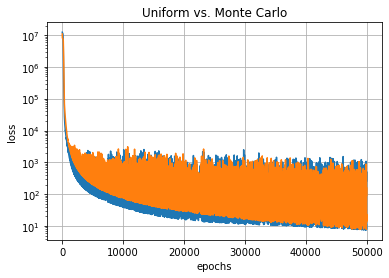

In [10]:
fig = plt.figure()
plt.semilogy(range(0, epochs), PDE_loss1, range(0, epochs), PDE_loss2)
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('Uniform vs. Monte Carlo')

plt.grid()
plt.show()

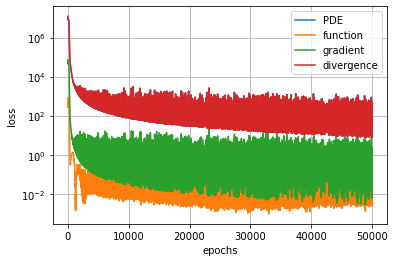

In [11]:
fig = plt.figure()
plt.semilogy(range(0, epochs), PDE_loss2, range(0, epochs), N_loss2, range(0, epochs), gradient_loss2, range(0, epochs), divergence_loss2)
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(['PDE','function','gradient','divergence'])

plt.grid()
plt.show()

## Results MC

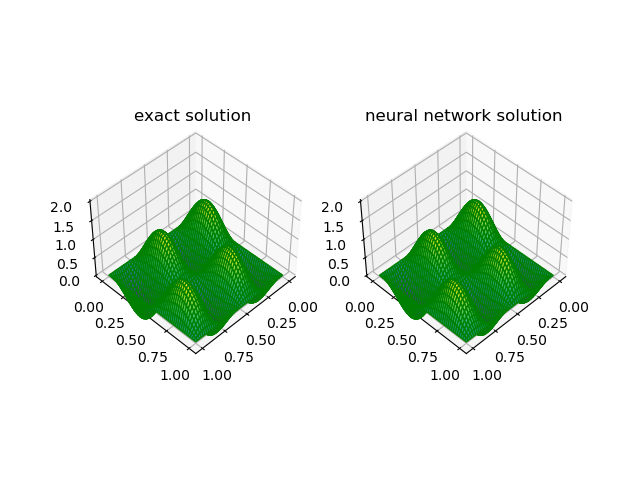

In [12]:
# for creating a responsive plot
%matplotlib widget

M_plot = 50

# plot the exact solution
x = np.outer(np.linspace(0,1,M_plot), np.ones(M_plot))
y = x.copy().T
z_true = np.sin(4*np.pi*x) * np.sin(2*np.pi*y)

fig = plt.figure()
ax = fig.add_subplot(121, projection='3d')

plot_exact = ax.plot_surface(x,y,z_true,cmap='viridis',edgecolor = 'green')
ax.set_zlim(0,2)
ax.view_init(45,45)
ax.set_title("exact solution")


# plot the neural network solution 
x = x.reshape(M_plot**2,1)
y = y.reshape(M_plot**2,1)
z_model = model5(np.concatenate((x, y), axis=1))
z_model = z_model.numpy().reshape(M_plot,M_plot)

x = x.reshape(M_plot,M_plot)
y = y.reshape(M_plot,M_plot)

ax = fig.add_subplot(122, projection='3d')

ax.plot_surface(x,y,z_model,cmap='viridis',edgecolor = 'green')
ax.set_zlim(0,2)
ax.view_init(45,45)
ax.set_title("neural network solution")
plt.show()


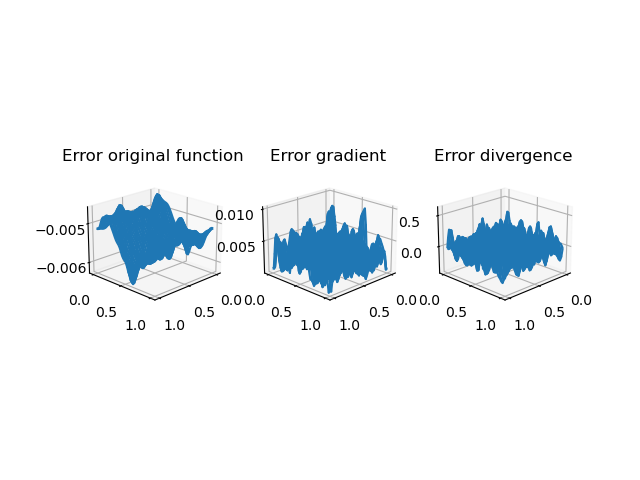

In [13]:
x_tensor = tf.convert_to_tensor(np.concatenate((x.reshape(M_plot*M_plot,1), y.reshape(M_plot*M_plot,1)), axis=1), dtype = float)

with tf.GradientTape() as tape:
        
        # Inner gradient for first derivative of N wrt x
        with tf.GradientTape(persistent=True) as tape1:
            tape1.watch(x_tensor)
            
            # Inner inner gradient for fi derivative of N wrt x
            with tf.GradientTape(persistent=True) as tape2:
                tape2.watch(x_tensor)
            
                N = model5(x_tensor)
            
            grad_N = tape2.gradient(N, x_tensor)
            Nx = grad_N[:, 0]
            Ny = grad_N[:, 1]
        Nxx = tape1.gradient(Nx, x_tensor)[:, 0]
        Nyy = tape1.gradient(Ny, x_tensor)[:, 1]
# error of original function
fig = plt.figure()
ax1 = fig.add_subplot(131, projection='3d')
function_error = N.numpy().reshape(M_plot,M_plot) - np.multiply (np.sin(4*np.pi*x),  np.sin(2*np.pi*y))
ax1.plot_wireframe(x,y,function_error)
ax1.view_init(20,45)
ax1.set_title("Error original function")

# error of the gradiant
ax1 = fig.add_subplot(132, projection='3d')
gradient_error = np.sqrt( np.square( Nx.numpy().reshape(M_plot,M_plot) - 4 * np.pi *\
        np.multiply (np.cos(4*np.pi*x) , np.sin(2*np.pi*y))) +\
                         np.square( Ny.numpy().reshape(M_plot,M_plot) - 2 * np.pi *\
        np.multiply (np.sin(4*np.pi*x) , np.cos(2*np.pi*y))))
ax1.plot_wireframe(x,y,gradient_error)
ax1.view_init(20,45)
ax1.set_title("Error gradient")

# error of the divergence
ax1 = fig.add_subplot(133, projection='3d')
divergence_error = (Nxx + Nyy).numpy().reshape(M_plot,M_plot) + 20 * np.pi**2 * \
        np.multiply(np.sin(4*np.pi*x) , np.sin(2*np.pi*y)) 
ax1.plot_wireframe(x,y,divergence_error)
ax1.view_init(20,45)
ax1.set_title("Error divergence")

plt.show()

## Results uniform

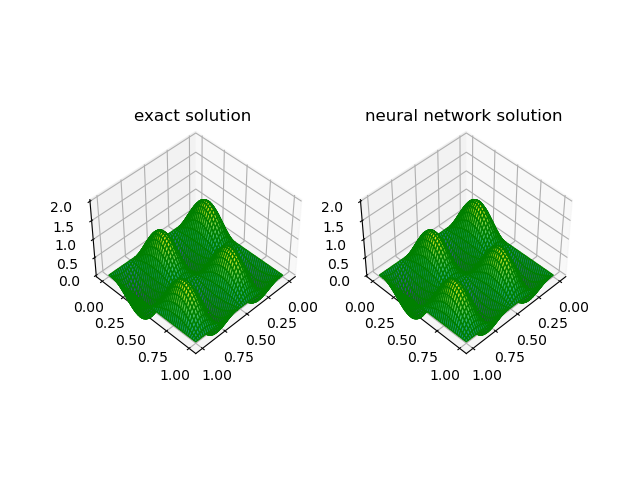

In [14]:
# for creating a responsive plot
%matplotlib widget

M_plot = 50

# plot the exact solution
x = np.outer(np.linspace(0,1,M_plot), np.ones(M_plot))
y = x.copy().T
z_true = np.sin(4*np.pi*x) * np.sin(2*np.pi*y)

fig = plt.figure()
ax = fig.add_subplot(121, projection='3d')

plot_exact = ax.plot_surface(x,y,z_true,cmap='viridis',edgecolor = 'green')
ax.set_zlim(0,2)
ax.view_init(45,45)
ax.set_title("exact solution")


# plot the neural network solution 
x = x.reshape(M_plot**2,1)
y = y.reshape(M_plot**2,1)
z_model = model6(np.concatenate((x, y), axis=1))
z_model = z_model.numpy().reshape(M_plot,M_plot)

x = x.reshape(M_plot,M_plot)
y = y.reshape(M_plot,M_plot)

ax = fig.add_subplot(122, projection='3d')

ax.plot_surface(x,y,z_model,cmap='viridis',edgecolor = 'green')
ax.set_zlim(0,2)
ax.view_init(45,45)
ax.set_title("neural network solution")
plt.show()


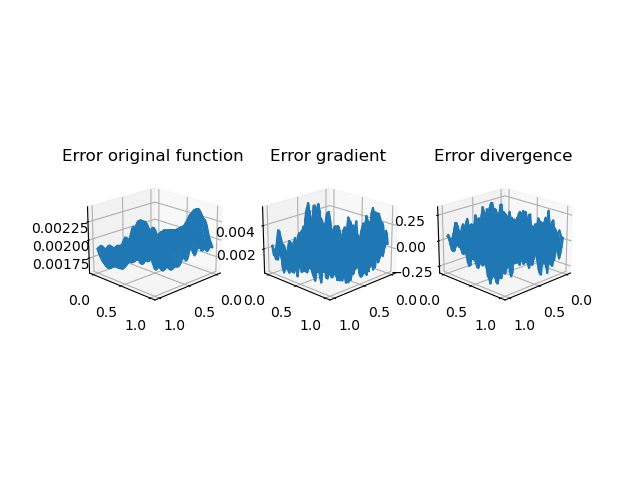

In [15]:
x_tensor = tf.convert_to_tensor(np.concatenate((x.reshape(M_plot*M_plot,1), y.reshape(M_plot*M_plot,1)), axis=1), dtype = float)

with tf.GradientTape() as tape:
        
        # Inner gradient for first derivative of N wrt x
        with tf.GradientTape(persistent=True) as tape1:
            tape1.watch(x_tensor)
            
            # Inner inner gradient for fi derivative of N wrt x
            with tf.GradientTape(persistent=True) as tape2:
                tape2.watch(x_tensor)
            
                N = model6(x_tensor)
            
            grad_N = tape2.gradient(N, x_tensor)
            Nx = grad_N[:, 0]
            Ny = grad_N[:, 1]
        Nxx = tape1.gradient(Nx, x_tensor)[:, 0]
        Nyy = tape1.gradient(Ny, x_tensor)[:, 1]
# error of original function
fig = plt.figure()
ax1 = fig.add_subplot(131, projection='3d')
function_error = N.numpy().reshape(M_plot,M_plot) - np.multiply (np.sin(4*np.pi*x),  np.sin(2*np.pi*y))
ax1.plot_wireframe(x,y,function_error)
ax1.view_init(20,45)
ax1.set_title("Error original function")

# error of the gradiant
ax1 = fig.add_subplot(132, projection='3d')
gradient_error = np.sqrt( np.square( Nx.numpy().reshape(M_plot,M_plot) - 4 * np.pi *\
        np.multiply (np.cos(4*np.pi*x) , np.sin(2*np.pi*y))) +\
                         np.square( Ny.numpy().reshape(M_plot,M_plot) - 2 * np.pi *\
        np.multiply (np.sin(4*np.pi*x) , np.cos(2*np.pi*y))))
ax1.plot_wireframe(x,y,gradient_error)
ax1.view_init(20,45)
ax1.set_title("Error gradient")

# error of the divergence
ax1 = fig.add_subplot(133, projection='3d')
divergence_error = (Nxx + Nyy).numpy().reshape(M_plot,M_plot) + 20 * np.pi**2 * \
        np.multiply(np.sin(4*np.pi*x) , np.sin(2*np.pi*y)) 
ax1.plot_wireframe(x,y,divergence_error)
ax1.view_init(20,45)
ax1.set_title("Error divergence")

plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


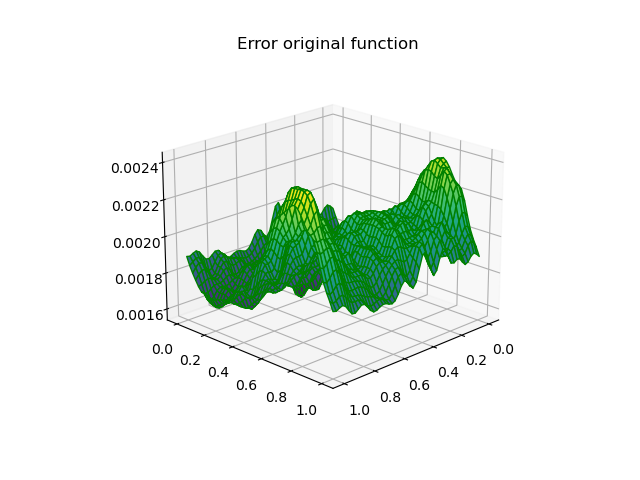

In [16]:
fig = plt.figure()
ax1 = plt.axes(projection='3d')
function_error = N.numpy().reshape(M_plot,M_plot) - np.multiply (np.sin(4*np.pi*x),  np.sin(2*np.pi*y))
ax1.plot_surface(x,y,function_error,cmap='viridis',edgecolor = 'green')
ax1.view_init(20,45)
ax1.set_title("Error original function")
plt.savefig('plot1.eps')

## Test the exact solution

In [17]:
def f_test1(x):
    return(tf.math.sin(4*np.pi* x[:,0]) *tf.math.sin(2*np.pi* x[:,1]))

In [18]:
x = tf.convert_to_tensor(input_data_uniform,dtype=tf.float32)
with tf.GradientTape(persistent=True) as tape6:
    tape6.watch(x)
    with tf.GradientTape(persistent=True) as tape5:
        tape5.watch(x)

        N = f_test1(x)
    grad_N = tape5.gradient(N, x)
    Nx = grad_N[:,0]
    Ny = grad_N[:,1]
Nxx = tape6.gradient(Nx, x)[:, 0]
Nyy = tape6.gradient(Ny, x)[:, 1] 

eqn = - (1 + 1/4 * np.sin(2*np.pi*x[:, 0]) * np.sin(2*np.pi*x[:, 1])) * (Nxx + Nyy + 20 * np.pi**2 * \
        np.sin(4*np.pi*x[:, 0]) * np.sin(2*np.pi*x[:, 1])) - \
        (np.pi/2 * np.cos(2*np.pi*x[:, 0]) * np.sin(2*np.pi*x[:, 1])) * (Nx - 4 * np.pi *\
        np.cos(4*np.pi*x[:, 0]) * np.sin(2*np.pi*x[:, 1])) - \
        (np.pi/2 * np.sin(2*np.pi*x[:, 0]) * np.cos(2*np.pi*x[:, 1])) * (Ny - 2 * np.pi *\
        np.sin(4*np.pi*x[:, 0]) * np.cos(2*np.pi*x[:, 1])) + nu * (N - np.sin(4*np.pi*x[:, 0]) * np.sin(2*np.pi*x[:, 1]))
print(eqn)

tf.Tensor(
[ 0.  0.  0.  0.  0.  0.  0.  0. -0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
 -0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. -0.  0.  0.  0.
 -0.  0.  0. -0.  0.  0.  0.  0.  0.  0. -0. -0. -0. -0. -0. -0. -0. -0.
 -0. -0. -0. -0. -0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0. -0.  0. -0. -0. -0. -0.  0. -0. -0.  0. -0. -0. -0. -0.  0.
  0.  0.  0. -0.  0.  0.  0. -0.  0. -0. -0. -0.  0.  0. -0. -0. -0. -0.
 -0. -0. -0. -0.  0. -0. -0.  0.  0. -0. -0.  0. -0.  0. -0.  0.  0. -0.
  0.  0.  0.  0.  0. -0.  0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0.
 -0. -0. -0. -0. -0. -0.  0. -0.  0.  0.  0.  0. -0.  0.  0.  0. -0.  0.
  0.  0.  0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. -0.  0.  0. -0.
 -0. -0. -0. -0.  0. -0. -0.  0.  0. -0. -0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0. -0.  0.  0.  0.  0. -0. -0. -0. -0. -0. -0. -0. -0. -0.
 -0.  0. -0. -0. -0.  0.  0. -0.  0. -0.